Imports

In [1]:
import numpy as np
import cv2
import glob
from tqdm import tqdm
import mediapy as media
from pycm import *

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16

from keras.layers import Input, Flatten, Dense, MaxPool2D, Conv2D, Concatenate
from keras.models import Model
from keras.models import Sequential

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

from keras.optimizers import Adam

Using TensorFlow backend.
/home/marrondantas/anaconda3/envs/kerasenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/marrondantas/anaconda3/envs/kerasenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/marrondantas/anaconda3/envs/kerasenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

Utils

In [1]:
files_soil = (glob.glob("Data/*soil.png"))
files_tree = (glob.glob("Data/*tree.png"))

print("Total files soil:",len(files_soil))
print("Total files tree:",len(files_tree))

Total files soil: 4448
Total files tree: 2224


## Generating initial dataset

In [2]:
#Generating labels
soil_label = np.zeros(len(files_soil))
soil_tree = np.ones(len(files_tree))

#Adding data format
X = files_soil + files_tree
y = np.hstack((soil_label,soil_tree))

#Spliting in train, test and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

#Printing output data format
print('Train samples: %i with %i Soil samples and %i Tree samples'%(len(X_train),np.sum(y_train),np.sum(1-y_train)))
print('Test samples: %i with %i Soil samples and %i Tree samples'%(len(X_test),np.sum(y_val),np.sum(1-y_test)))
print('Val samples: %i with %i Soil samples and %i Tree samples'%(len(X_val),np.sum(y_val),np.sum(1-y_val)))

Train samples: 5337 with 1782 Soil samples and 3555 Tree samples
Test samples: 668 with 220 Soil samples and 446 Tree samples
Val samples: 667 with 220 Soil samples and 447 Tree samples


## Creating the custom dataloader

* Data augmetantion on the fly

Using TensorFlow backend.
/home/marrondantas/anaconda3/envs/kerasenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/marrondantas/anaconda3/envs/kerasenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/marrondantas/anaconda3/envs/kerasenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

Aug sample

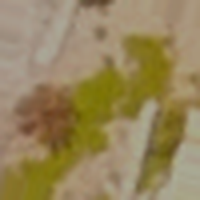

Aug sample

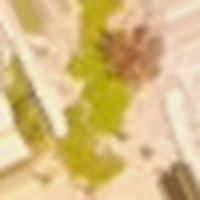

In [3]:
#Getting a custom data augmentation setup 
def get_augmented(x,y,total_samples):
    
    x_aug = []
    y_aug = []
    
    #Minimal data augmentation
    datagen = ImageDataGenerator(
        rotation_range=90,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.5,1])
    
    #Getting iteratos
    for i in range(total_samples):
    
        x_partial, y_partial = next(datagen.flow(x,y, batch_size=total_samples))
        x_aug.append(x_partial[0])
        y_aug.append(y_partial[0])
    
    return np.asarray(x_aug), np.asarray(y_aug)

#Showing a sample of the generate images
x_ = np.asarray([cv2.imread(X_train[3000])])
y_ = np.asarray([y_train[3000]])

aug_x, aug_y = get_augmented(x_,y_,2)

media.show_image(media.resize_image(cv2.cvtColor(aug_x[0].astype('uint8'),cv2.COLOR_BGR2RGB),(200,200)),title='Aug sample')
media.show_image(media.resize_image(cv2.cvtColor(aug_x[1].astype('uint8'),cv2.COLOR_BGR2RGB),(200,200)),title='Aug sample')

Data loader

* Generating the customs loaders for the training and validation

In [8]:
def data_loader(paths, labels, batch_size = 5, size_aug = -1, data_augmentation=False):
    
    begin = 0
    end   = batch_size
    
    while True:
        
        partial_x = paths[begin:end]
        out_y = labels[begin:end]
        
        out_x = []
        
        for i in range(len(partial_x)):
            
            img = cv2.imread(partial_x[i])
            img = img/255.0
            out_x.append(img)
            
        if (data_augmentation):
            
            aug_x, aug_y = get_augmented(np.asarray(out_x),out_y,size_aug)
            for img in aug_x: out_x.append(img)
            out_y = np.hstack((out_y,aug_y))
            
        yield np.asarray(out_x), np.asarray(out_y)
        
        begin = end
        end += batch_size
        
        if (end>=len(paths)):
            
            begin = 0
            end = batch_size
            
def vgg_loader(paths, labels, batch_size = 5, size_aug = -1, data_augmentation=False):
    
    begin = 0
    end   = batch_size
    
    while True:
        
        partial_x = paths[begin:end]
        out_y = labels[begin:end]
        
        out_x = []
        
        for i in range(len(partial_x)):
            
            img = load_img(partial_x[i])
            img = img_to_array(img)
            img = preprocess_input(img)
            out_x.append(img)
            
        if (data_augmentation):
            
            aug_x, aug_y = get_augmented(np.asarray(out_x),out_y,size_aug)
            for img in aug_x: out_x.append(img)
            out_y = np.hstack((out_y,aug_y))
            
        yield np.asarray(out_x), np.asarray(out_y)
        
        begin = end
        end += batch_size
        
        if (end>=len(paths)):
            
            begin = 0
            end = batch_size         
            
train_loader = data_loader(X_train, y_train, batch_size = 5, size_aug = 5, data_augmentation=True)
val_loader = data_loader(X_val, y_val, batch_size = 5)

# Transfer Learning

In [35]:
model = VGG16(include_top=False, input_shape=(50, 50, 3))

for layer in model.layers:
    layer.trainable = False

x = Flatten()(model.layers[-1].output)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=model.input, outputs=x)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 50, 50, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 50, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 50, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 25, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 25, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 25, 25, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

In [36]:
#Compile
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [37]:
model.load_weights('vgg_classifier.h5')

In [38]:
#VGG Loader
train_loader = vgg_loader(X_train, y_train, batch_size = 5, size_aug = 5, data_augmentation=True)
val_loader = vgg_loader(X_val, y_val, batch_size = 5)

#Callbacks
mc1 = ModelCheckpoint('vgg_classifier.h5', monitor='loss', mode='min', verbose=1, save_best_only=True)
mc2 = ModelCheckpoint('vgg_loss_classifier.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)
callbacks=[mc1,mc2,reduce_lr]

#Fit model
STEP_SIZE_TRAIN=len(X_train)//5
STEP_SIZE_VALIDATION=len(X_val)//5

hist = model.fit_generator(
   train_loader,
   epochs=50,
   steps_per_epoch=STEP_SIZE_TRAIN,
   validation_data=val_loader,
   validation_steps=STEP_SIZE_VALIDATION,
   verbose=1,
   callbacks=callbacks
)

Epoch 1/50
1067/1067 [==============================] - 66s 62ms/step - loss: 0.2455 - acc: 0.9010 - val_loss: 0.4351 - val_acc: 0.8722

Epoch 00001: loss improved from inf to 0.24555, saving model to vgg_classifier.h5

Epoch 00001: val_loss improved from inf to 0.43506, saving model to vgg_loss_classifier.h5
Epoch 2/50
1067/1067 [==============================] - 69s 65ms/step - loss: 0.2346 - acc: 0.9073 - val_loss: 0.4567 - val_acc: 0.8662

Epoch 00002: loss improved from 0.24555 to 0.23458, saving model to vgg_classifier.h5

Epoch 00002: val_loss did not improve from 0.43506
Epoch 3/50
1067/1067 [==============================] - 68s 64ms/step - loss: 0.2280 - acc: 0.9097 - val_loss: 0.4847 - val_acc: 0.8647

Epoch 00003: loss improved from 0.23458 to 0.22799, saving model to vgg_classifier.h5

Epoch 00003: val_loss did not improve from 0.43506
Epoch 4/50
1067/1067 [==============================] - 69s 65ms/step - loss: 0.2127 - acc: 0.9179 - val_loss: 0.4653 - val_acc: 0.8677

Ep


Epoch 00031: val_loss did not improve from 0.43506
Epoch 32/50
1067/1067 [==============================] - 68s 64ms/step - loss: 0.1298 - acc: 0.9507 - val_loss: 1.1221 - val_acc: 0.8662

Epoch 00032: loss did not improve from 0.11911

Epoch 00032: val_loss did not improve from 0.43506
Epoch 33/50
1067/1067 [==============================] - 68s 64ms/step - loss: 0.1292 - acc: 0.9493 - val_loss: 1.0471 - val_acc: 0.8677

Epoch 00033: loss did not improve from 0.11911

Epoch 00033: val_loss did not improve from 0.43506
Epoch 34/50
1067/1067 [==============================] - 68s 64ms/step - loss: 0.1173 - acc: 0.9534 - val_loss: 1.0981 - val_acc: 0.8662

Epoch 00034: loss improved from 0.11911 to 0.11732, saving model to vgg_classifier.h5

Epoch 00034: val_loss did not improve from 0.43506
Epoch 35/50
1067/1067 [==============================] - 68s 64ms/step - loss: 0.1134 - acc: 0.9547 - val_loss: 1.0887 - val_acc: 0.8752

Epoch 00035: loss improved from 0.11732 to 0.11336, saving m

In [39]:
hist2 = model.fit_generator(
   train_loader,
   epochs=10,
   steps_per_epoch=STEP_SIZE_TRAIN,
   validation_data=val_loader,
   validation_steps=STEP_SIZE_VALIDATION,
   verbose=1,
   callbacks=callbacks
)

Epoch 1/10
1067/1067 [==============================] - 69s 64ms/step - loss: 0.1154 - acc: 0.9531 - val_loss: 1.1141 - val_acc: 0.8752

Epoch 00001: loss did not improve from 0.10897

Epoch 00001: val_loss did not improve from 0.43506
Epoch 2/10
1067/1067 [==============================] - 68s 64ms/step - loss: 0.1126 - acc: 0.9538 - val_loss: 1.0856 - val_acc: 0.8722

Epoch 00002: loss did not improve from 0.10897

Epoch 00002: val_loss did not improve from 0.43506
Epoch 3/10
1067/1067 [==============================] - 68s 64ms/step - loss: 0.1127 - acc: 0.9528 - val_loss: 1.0935 - val_acc: 0.8767

Epoch 00003: loss did not improve from 0.10897

Epoch 00003: val_loss did not improve from 0.43506
Epoch 4/10
1067/1067 [==============================] - 68s 64ms/step - loss: 0.1102 - acc: 0.9555 - val_loss: 1.1128 - val_acc: 0.8767

Epoch 00004: loss did not improve from 0.10897

Epoch 00004: val_loss did not improve from 0.43506
Epoch 5/10
1067/1067 [==============================] - 

# Classification model

In [5]:
#Base model
model = Sequential()

model.add(Conv2D(input_shape=(50,50,3),filters=32,kernel_size=(3,3),activation="relu", name='input_base'))
model.add(MaxPool2D(pool_size=(1,1)))
model.add(Conv2D(filters=16,kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(1,1)))
model.add(Conv2D(filters=8,kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(1,1)))
model.add(Conv2D(filters=4,kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(1,1)))

#Classifier
model.add(Flatten(name='output_flatten'))
model.add(Dense(units=32,activation="relu"))
model.add(Dense(units=16,activation="relu"))
model.add(Dense(units=8,activation="relu",name='output_dense'))
model.add(Dense(units=1, activation="sigmoid"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_base (Conv2D)          (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 46, 46, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 8)         1160      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 44, 44, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 42, 42, 4)         292       
__________

* Training the model

In [6]:
#Compile
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
#Callbacks
mc1 = ModelCheckpoint('classifier.h5', monitor='loss', mode='min', verbose=1, save_best_only=True)
mc2 = ModelCheckpoint('loss_classifier.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)
callbacks=[mc1,mc2,reduce_lr]

#Fit model
STEP_SIZE_TRAIN=len(X_train)//5
STEP_SIZE_VALIDATION=len(X_val)//5

hist = model.fit_generator(
   train_loader,
   epochs=10,
   steps_per_epoch=STEP_SIZE_TRAIN,
   validation_data=val_loader,
   validation_steps=STEP_SIZE_VALIDATION,
   verbose=1,
   callbacks=callbacks
)

In [7]:
model.load_weights('weights/loss_classifier.h5')

Evaluate Base Model

In [8]:
test_loader = data_loader(X_test, y_test, batch_size = 5)
STEP_SIZE_TEST=len(X_test)//5
model.evaluate_generator(test_loader,steps = STEP_SIZE_TEST,verbose=1)

133/133 [==============================] - 2s 13ms/step


[0.24434927634280385, 0.9203007566301447]

In [12]:
pred = []
ground = []

STEP_SIZE_TEST=len(X_test)//5
test_loader = data_loader(X_test, y_test, batch_size = 5)

for i in tqdm(range(STEP_SIZE_TEST)):

    x, y = next(test_loader)
    
    ground.extend(list(y))
    
    predictions = model.predict_on_batch(x)
    
    predictions[predictions>=0.5]=1
    predictions[predictions<0.5]=0
    
    pred.extend(list(predictions.flatten()))

100%|██████████| 133/133 [00:01<00:00, 75.68it/s]


In [13]:
pred = np.asarray(pred).astype(int)
ground = np.asarray(ground).astype(int)

In [16]:
cm = ConfusionMatrix(actual_vector=ground, predict_vector=pred)
print(cm)

Predict   0         1         
Actual
0         422       22        

1         31        190       





Overall Statistics : 

95% CI                                                            (0.89972,0.94089)
ACC Macro                                                         0.9203
ARI                                                               0.70186
AUNP                                                              0.90509
AUNU                                                              0.90509
Bangdiwala B                                                      0.8637
Bennett S                                                         0.8406
CBA                                                               0.89565
CSI                                                               0.81899
Chi-Squared                                                       445.98961
Chi-Squared DF                                                    1
Conditional Entropy                                   

<AxesSubplot:title={'center':'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

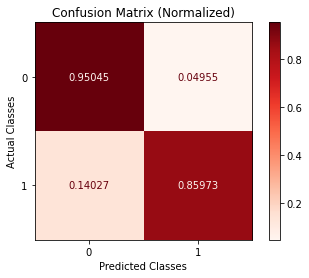

In [17]:
import matplotlib.pyplot as plt

cm.plot(cmap=plt.cm.Reds,normalized=True,number_label=True)

Mixed Model

In [7]:
def get_splited_hist(img):
    
    scaler = MinMaxScaler()
    
    b,g,r = cv2.split(img)

    hist_b = cv2.calcHist([b],[0],None,[256],[0,256])
    hist_g = cv2.calcHist([g],[0],None,[256],[0,256])
    hist_r = cv2.calcHist([r],[0],None,[256],[0,256])

    hist_data = hist_b.flatten() + hist_g.flatten() + hist_r.flatten()

    return scaler.fit_transform(hist_data.reshape(-1,1)).flatten()

def data_loader_mixed(paths, labels, batch_size = 5, size_aug = -1, data_augmentation=False):
    
    begin = 0
    end   = batch_size
    
    while True:
        
        partial_x = paths[begin:end]
        out_y = labels[begin:end]
        
        out_x    = []
        out_hist = []
        
        for i in range(len(partial_x)):
            
            img = cv2.imread(partial_x[i])
            
            hist_data = get_splited_hist(img)
            out_hist.append(hist_data)    
                
            img = img/255.0
            out_x.append(img)
            
        if (data_augmentation):
            
            aug_x, aug_y = get_augmented(np.asarray(out_x),out_y,size_aug)
            for img in aug_x: out_x.append(img)
            for img in aug_x: out_hist.append(get_splited_hist(img))
            out_y = np.hstack((out_y,aug_y))
            
        yield [np.asarray(out_x),np.asarray(out_hist)], np.asarray(out_y)
        
        begin = end
        end += batch_size
        
        if (end>=len(paths)):
            
            begin = 0
            end = batch_size
            
train_loader_mixed = data_loader_mixed(X_train, y_train, batch_size = 5, size_aug = 5, data_augmentation=True)
x_data, y = next(train_loader_mixed)
x_data[0].shape,x_data[1].shape,y.shape

((10, 50, 50, 3), (10, 256), (10,))

Mixed Model

In [19]:
input_tab = Input(shape=(256,),name='input_conc')
output_dense = model.get_layer('output_flatten').output
g = Dense(units=256,activation="relu")(output_dense)

concatenate_layer = Concatenate()([g,input_tab])

conc_mix = Model([model.input,input_tab],concatenate_layer)

x = Dense(units=128,activation="relu")(conc_mix.output)
x = Dense(units=32,activation="relu")(x)
x = Dense(units=16,activation="relu")(x)
x = Dense(units=8,activation="relu")(x)
x = Dense(units=1, activation="sigmoid")(x)

mixed_model = Model([conc_mix.get_layer('input_base_input').output,conc_mix.get_layer('input_conc').output],x)

mixed_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_base_input (InputLayer)   (None, 50, 50, 3)    0                                            
__________________________________________________________________________________________________
input_base (Conv2D)             (None, 48, 48, 32)   896         input_base_input[0][0]           
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 48, 48, 32)   0           input_base[0][0]                 
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 46, 46, 16)   4624        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

Training Model

In [33]:
STEP_SIZE_TRAIN=len(X_train)//5
STEP_SIZE_VALIDATION=len(X_val)//5

In [104]:
#Mixed loader
train_loader = data_loader(X_train, y_train, batch_size = 5, size_aug = 5, data_augmentation=True)
val_loader_mixed = data_loader_mixed(X_val, y_val, batch_size = 5)

#Callbacks
mc1 = ModelCheckpoint('single_classifier_aug.h5', monitor='loss', mode='min', verbose=1, save_best_only=True)
mc2 = ModelCheckpoint('single_loss_classifier_aug.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001, verbose=1)
callbacks=[mc1,mc2,reduce_lr]

#Compile Model
opt = Adam(lr=0.001)

mixed_model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

#Fit model
STEP_SIZE_TRAIN=len(X_train)//5
STEP_SIZE_VALIDATION=len(X_val)//5

hist = mixed_model.fit_generator(
   train_loader_mixed,
   epochs=1,
   steps_per_epoch=STEP_SIZE_TRAIN,
   validation_data=val_loader_mixed,
   validation_steps=STEP_SIZE_VALIDATION,
   verbose=1,
   callbacks=callbacks
)

Epoch 1/1
1067/1067 [==============================] - 44s 41ms/step - loss: 0.4413 - acc: 0.7807 - val_loss: 0.1895 - val_acc: 0.9383

Epoch 00001: loss improved from inf to 0.44130, saving model to single_classifier_aug.h5

Epoch 00001: val_loss improved from inf to 0.18949, saving model to single_loss_classifier_aug.h5


In [50]:
mixed_model.load_weights('weights/mixed_model_loss_classifier.h5')
mixed_model.save('best_model.h5')

In [38]:
opt = Adam(lr=0.001)
mixed_model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [39]:
test_loader = data_loader_mixed(X_test, y_test, batch_size = 5)
STEP_SIZE_TEST=len(X_test)//5
mixed_model.evaluate_generator(test_loader,steps = STEP_SIZE_TEST,verbose=1)

133/133 [==============================] - 1s 7ms/step


[0.17811281751724017, 0.9368421090276617]

In [40]:
pred = []
ground = []

STEP_SIZE_TEST=len(X_test)//5
test_loader = data_loader_mixed(X_test, y_test, batch_size = 5)

for i in tqdm(range(STEP_SIZE_TEST)):

    x, y = next(test_loader)
    
    ground.extend(list(y))
    
    predictions = mixed_model.predict_on_batch(x)
    
    predictions[predictions>=0.5]=1
    predictions[predictions<0.5]=0
    
    pred.extend(list(predictions.flatten()))

/home/marrondantas/anaconda3/envs/kerasenv/lib/python3.6/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [53]:
x.shape

(5, 50, 50, 3)

In [41]:
pred = np.asarray(pred).astype(int)
ground = np.asarray(ground).astype(int)

In [42]:
cm = ConfusionMatrix(actual_vector=ground, predict_vector=pred)
print(cm)

Predict   0         1         
Actual
0         423       21        

1         21        200       





Overall Statistics : 

95% CI                                                            (0.91835,0.95533)
ACC Macro                                                         0.93684
ARI                                                               0.76
AUNP                                                              0.92884
AUNU                                                              0.92884
Bangdiwala B                                                      0.89004
Bennett S                                                         0.87368
CBA                                                               0.92884
CSI                                                               0.85768
Chi-Squared                                                       489.18405
Chi-Squared DF                                                    1
Conditional Entropy                                   

<AxesSubplot:title={'center':'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

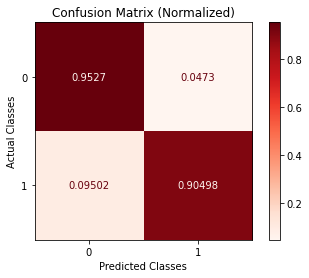

In [44]:
cm.plot(cmap=plt.cm.Reds,normalized=True,number_label=True)